
[Colab link ](https://drive.google.com/file/d/1HmvrkYaFIpb9l7d9RgZpcffEBTkbej60/view?usp=sharing)


## Importing

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.svm import SVC

import os

from tqdm.auto import tqdm

import shutil

from itertools import groupby

import matplotlib.pyplot as plt

from statistics import mean

import scipy.stats as stats
from scipy.stats import skew
from scipy.stats import kurtosis

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Parameters

In [ ]:
# path of original data folder
data_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data"
# path of csv files, each file is a 2mins walk for a subject
csvD_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/csv_files"
# In this file, the Null values are replaved with 0 in the HY scale - Null values were given to healthy control
demographics = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/Processed_data/demographics_HYprocessed.csv" 
dem_df = pd.read_csv(demographics)
# parequet folder path
parquet_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/parquet_files/"

## Data Utils

#### Data Class

Note: 
Gait cycle = stride cycle


- Usually, Vertical Ground React Force VGRF values less than 20N are generated from noise
- For gait cycle segmentation, to eliminate the effect of gait initiation and termenation, the first and last 20 seconds of VGRF data was discarded.
- Note: Since we are deleting the first and last 20 seconds, some patients that performed less than 2 mins have almost no gait cycles left. For example, the paient with Id `JuCo02` and `JuCo03` walked for almost 40.40 seconds. Thus, after deleting the first and last 20 sec, he has only half gait cycle left. 

*   stride time variability and swing time variability are important parameters in distinguishing a PD patient’s gait from normal gait.
*   As PD patients tend to put less pressure during placing the heel strike and toe off than control subjects, maximum VGRF at heel strike and toe off for each gait cycle was computed. The mean and standard deviation of the VGRF overall gait cycles were taken as features for classification.




In [ ]:
class Data:
  def __init__(self, prepare_or_get, data_folder, demographics_file, parquet_path):
    '''
    :param prepare_or_get:  1: prepare data , 0: load preloaded datas (npy)
    :param data_folder: path for a folder containing csv files, file for each 2 mins walk (for indivdiual subject)
    :param demographics_file: path for csv demographics file
    :save_path: path where to save/read parquet files after preparing them
    :
    '''

    self.data_path = data_folder
    self.parquet_path= parquet_path
    self.dem_path= demographics_file
    self.scale="HoehnYahr"            # fixed for now
    self.seconds_to_discard = 20      # fixed for now
    self.rows_to_discard = 100 * self.seconds_to_discard
    
    # data in arrays
    self.signals_data = []
    self.cycles_data=[]
    self.statical_data=[]
  

    if (prepare_or_get==1):
      self.prepare_data()
    elif (prepare_or_get==0):
      self.get_data()
  
  def get_data(self):
    self.signals_data_df= pd.read_parquet(self.parquet_path+'signals.gzip')
    self.cycles_data_df=pd.read_parquet(self.parquet_path+'cyclels.gzip')
    self.statical_data_df=pd.read_parquet(self.parquet_path+'statical.gzip')
    self.left_stances_df=pd.read_parquet(self.parquet_path+'left_stances.gzip')
    self.right_stances_df=pd.read_parquet(self.parquet_path+'right_stances.gzip')

  def prepare_data(self):
    # loop over files, each file is a 2 min walk for a single individual
    # files are expected to be in csv format
    self.dem_df = pd.read_csv(self.dem_path)
    for name in tqdm((os.listdir(self.data_path))):
       
      # id of subject
      id = name.split('_')[0]

      # disease level according to 'self.scale'
      level = self.get_pd_level( id)

      # parkinon's patient OR healthy control ?
      if 'Co' in name:  
        parkinson = 0 # Healthy control
      elif 'Pt' in name:
        parkinson = 1 # Parkinson's Patient

      # read and filter one file
      one_walk=self.read_filter(name)

      # sum of values from all the left sensors
      one_walk['Total_Force_Left'] = one_walk[list(one_walk.columns[0:8])].sum(axis=1)
     
      # sum of values from all the right sensors
      one_walk['Total_Force_Right'] = one_walk[list(one_walk.columns[8:16])].sum(axis=1)
      
      # convert to lists
      one_walk_lists=[]*18
      for column in one_walk.columns.values.tolist():
        one_walk_lists.append(one_walk[column].tolist()) 

      ## Left foot related ##
      l_stances, l_strides_time , l_swings_time, l_stances_time, l_indices = self.segment_signal(one_walk_lists[16])
      # Find maximum VGRF at heel strike for each gait cycle 
      l_peaks_heel = self.get_max_per_gait_cycle(one_walk_lists[0],l_indices) # sensor 0 = left heal sensor
      # Find maximum VGRF at toe off for each gait cycle
      l_peaks_toe = self.get_max_per_gait_cycle(one_walk_lists[7],l_indices) # sensor 7 = left toe sensor

      ## right foot related ##
      r_stances, r_strides_time , r_swings_time, r_stances_time, r_indices = self.segment_signal(one_walk_lists[17])
      # Find maximum VGRF at heel strike for each gait cycle 
      r_peaks_heel = self.get_max_per_gait_cycle(one_walk_lists[8],l_indices) # sensor 8 = right heal sensor
      # Find maximum VGRF at toe off for each gait cycle
      r_peaks_toe = self.get_max_per_gait_cycle(one_walk_lists[15],l_indices) # sensor 15 = right toe sensor


      ## Saving data ##

      # Raw Signals
      self.signals_data.append([id,level,parkinson] +one_walk_lists)

      # Statical
      self.statical_data.append( [ id, level, parkinson 
                                , mean (l_swings_time) , np.std(l_swings_time), (mean (l_swings_time) / np.std(l_swings_time) *100)
                                , mean (l_strides_time) , np.std(l_strides_time) , (mean (l_strides_time) / np.std(l_strides_time)*100)
                                , kurtosis(l_strides_time), skew(l_strides_time)
                                , mean (l_stances_time) , np.std(l_stances_time) , ( mean (l_stances_time) / np.std(l_stances_time) *100) 

                                , mean (r_swings_time) , np.std(r_swings_time), (mean (r_swings_time) / np.std(r_swings_time) *100)
                                , mean (r_strides_time) , np.std(r_strides_time) , (mean (r_strides_time) / np.std(r_strides_time)*100)
                                , kurtosis(r_strides_time), skew(r_strides_time)
                                , mean (r_stances_time) , np.std(r_stances_time) , ( mean (r_stances_time) / np.std(r_stances_time) *100)
                                
                                , mean (l_peaks_heel) , np.std(l_peaks_heel) ,mean (l_peaks_toe) , np.std(l_peaks_toe)
                                , mean (r_peaks_heel) , np.std(r_peaks_heel) ,mean (r_peaks_toe) , np.std(r_peaks_toe)
                                  ] )
      
      
      # Segmented Signals
      
      # NEED TO BE MOVED TO SEPERATE FUNCTION
      # only for segmented data, for a trial we need each stance phase with the following 
      # swing phases's time, so here we are adjusting the phases to be equal

      dif_l =  len(l_stances)-len(l_swings_time)
      if (dif_l > 0):
        l_stances=l_stances[:-dif_l]
      elif(dif_l < 0):
        l_swings_time= l_swings_time[:dif_l]

      
      dif_r =  len(r_stances)-len(r_swings_time)
      if (dif_r>0):
        r_stances=r_stances[:-dif_r]
      elif(dif_r < 0):
        r_swings_time = r_swings_time[:dif_r]
       
      self.cycles_data.append( [ id, level, parkinson ] 
                              + [l_stances] + [l_strides_time] + [l_swings_time] + [l_stances_time]
                              + [r_stances] + [r_strides_time] + [r_swings_time] + [r_stances_time]
                              + [l_peaks_heel] + [l_peaks_toe]
                              + [r_peaks_heel] + [r_peaks_toe]
                              )
      

    self.statical_data_to_df()
    self.cycles_data_to_df()
    self.signal_data_to_df()
    ## Get individual stances data frames
    self.ind_stances_to_df()
    ## writing files ##
    self.save_files()

  def get_pd_level(self, subject_id):
    level = self.dem_df[self.scale][dem_df['ID'] == subject_id ].values[0]
    return level

  def read_filter(self,name):
      # Reading each file, skipping 3 columns (time,total right forces & total left forces)
      # For gait cycle segmentation, to eliminate the effect of gait initiation and termenation,
      # the first and last N=20 seconds of VGRF data was discarded.

      one_walk = pd.read_csv(self.data_path + '/' + name,
                             skiprows=list(range(1,self.rows_to_discard+1)) ,
                             skipfooter=self.rows_to_discard,
                             usecols = np.arange(1,17),
                             engine = 'python')  
      
      # Usually, Vertical Ground React Force VGRF values less than 20N are generated from noise
      one_walk.where(one_walk > 20, 0, inplace=True)

      return one_walk

  def segment_signal(self, signal):
      # swing - stance phases repeatly
      phases = [list(g) for k, g in groupby((signal), lambda x:x>0)]
      
      # Deleting the first and last phase, since the first and last 20 seconds were deleted,
      # there's no garanty that the first and last phase are complete
      # Hence, they are being deleted here just for safety

      phases = phases[1:-1]

      # filtering phases that is shorter than 20 becuase must propably it's noise
      phases = [l for l in phases if len(l)>20]

      # indices of the gait cycles
      indices=[0]
      for i in range(1, len(phases),2):
        indices.append(indices[-1]+len(phases[i]) + len(phases[i-1]))

      # stances phases
      stances = [l for l in phases if any(l)]
      
      # strides times 
      strides_time =  [((len(phases[i]) + len(phases[i-1]) -1)*0.01 ) for i in range(1,len(phases),2)]

      # swings time
      swings_time = [(len(l)-1)*0.01 for l in phases if not all (l)]

      # stance time 
      stances_time = [(len(l)-1)*0.01 for l in stances]

      return stances, strides_time , swings_time, stances_time, indices

  def get_max_per_gait_cycle(self, signal,indices):
    gait_cycles = self.get_gait_cycles(signal, indices)
    peaks = [max(cycle) for cycle in gait_cycles]
    return peaks

  def get_gait_cycles(self, signal, indices):
    # get gait cycles
    gait_cycles= [signal[indices[i]:indices[i+1]] for i in range(len(indices)-1)]
    return gait_cycles

  def signal_data_to_df(self):
    self.signals_data_df = pd.DataFrame(self.signals_data, columns =["ID", "level", "y", "L1", "L2","L3", "L4","L5","L6","L7","L8",
                                       "R1", "R2","R3", "R4","R5","R6","R7","R8","Total_Force_Right","Total_Force_Left" ])
     
    
  def cycles_data_to_df(self):
    self.cycles_data_df = pd.DataFrame(self.cycles_data, columns =["ID", "level", "y", 
                                                                   "l_stances", "l_strides_time", "l_swings_time" , "l_stances_time"
                                                                  , "r_stances" , "r_strides_time" , "r_swings_time" , "r_stances_time"
                                                                  , "l_peaks_heel" , "l_peaks_toe"
                                                                  , "r_peaks_heel" , "r_peaks_toe" ])
    

  def statical_data_to_df(self):
    self.statical_data_df = pd.DataFrame(self.statical_data, columns =["ID", "level", "y"
                                                                      , "mean_left_swings_time" , "std_left_swings_time", "cv_left_swings_time"
                                                                      , "mean_left_stride_time" , "std_left_stride_time" ,"cv_left_stride_time"
                                                                      , "kurtosis_left_strides_time", "skew_left_strides_time"
                                                                      , "mean_left_stance_time" , "std_left_stance_time", "cv_left_stance_time"
                                                                      , "mean_right_swings_time" , "std_right_swings_time", "cv_right_swings_time"
                                                                      , "mean_right_stride_time" , "std_right_stride_time", "cv_right_stride_time"
                                                                      , "kurtosis_right_strides_time", "skew_right_strides_time"
                                                                      , "mean_right_stance_time" , "std_right_stance_time", "cv_right_stance_time"
                                                                      , "mean_left_peaks_heel" , "std_left_peaks_heel"
                                                                      , "mean_left_peaks_toe" , "std_left_peaks_toe"
                                                                      , "mean_right_peaks_heel" , "std_right_peaks_heel"
                                                                      , "mean_right_peaks_toe" , "std_right_peaks_toe"
                                                                       ])
  def ind_stances_to_df(self):
    #droping NNOT WORKING HERE
    self.left_stances_df = self.cycles_data_df.explode(["l_stances","l_swings_time"])
    self.left_stances_df = self.left_stances_df.drop(columns=["r_stances" ,	"r_strides_time" ,	"r_swings_time" ,	"r_stances_time", "r_peaks_heel" ,	"r_peaks_toe"], axis=1)

    self.right_stances_df = self.cycles_data_df.explode(["r_stances","r_swings_time"])
    self.right_stances_df = self.right_stances_df.drop(columns=["l_stances" ,	"l_strides_time" ,	"l_swings_time" ,	"l_stances_time", "l_peaks_heel" ,	"l_peaks_toe"], axis=1)

  def save_files(self):
    self.signals_data_df.to_parquet(self.parquet_path+'signals.gzip')
    self.cycles_data_df.to_parquet(self.parquet_path+'cyclels.gzip')
    self.statical_data_df.to_parquet(self.parquet_path+'statical.gzip')
    self.left_stances_df.to_parquet(self.parquet_path+'left_stances.gzip')
    self.right_stances_df.to_parquet(self.parquet_path+'right_stances.gzip')

### Prepare the data

In [ ]:
data = Data( 1, csvD_path, demographics,parquet_path)

  0%|          | 0/304 [00:00<?, ?it/s]

In [ ]:
data.cycles_data_df

### Read already prepared data

In [ ]:
data = Data( 0, "", "",parquet_path)

In [ ]:
type(data.signals_data_df["L1"].iloc[-1]) 

numpy.ndarray

### Example

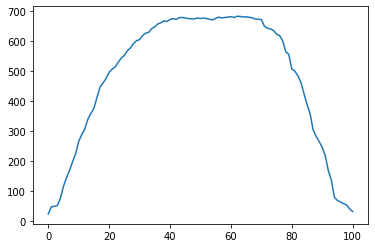

In [ ]:
# example of one stance phase 
y = data.left_stances_df['l_stances'].iloc[7]
import matplotlib.pyplot as plt
plt.plot(y)

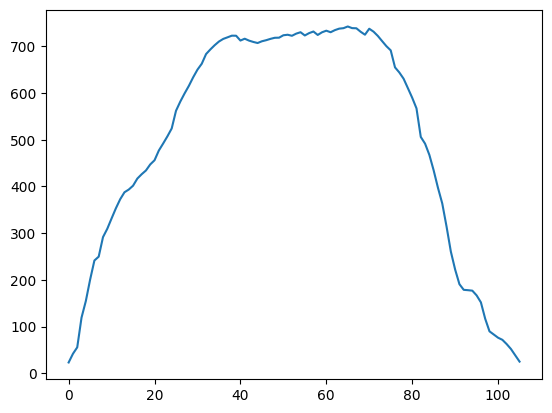

In [ ]:
# example of one stance phase 
y = data.right_stances_df['r_stances'].iloc[3]
import matplotlib.pyplot as plt
plt.plot(y)

### FWHM


In [ ]:
def fwhm(y_values_temp, x_values):
    y_values, temp_l, temp_r = [], [], []
    ## print(y_values_temp, x_values)
    # To make 'y_values_temp', a numpy array, into a python list
    for x in range(0,len(y_values_temp)):
        y_values.append(y_values_temp[x])
    peak_height = max(y_values)
    half_peak_height = max(y_values)/2
    
    # Splitting the y_values data into before and after x_value at peak height
    y_l_temp = y_values[0:y_values.index(peak_height)]
    y_r_temp = y_values[y_values.index(peak_height):len(y_values)]
    
    # Find 1st closest value to half_peak_height in y_l and y_r
    y_l = [abs(x-half_peak_height) for x in y_l_temp] # the distances
    y_l_min = min(y_l)
    point_left=y_l_temp[y_l.index(y_l_min)]  
    
    y_r = [abs(x-half_peak_height) for x in y_r_temp] # the distances
    point_right=y_r_temp[y_r.index(min(y_r))]  
    
    # y_l = nsmallest(1, y_l_temp, key=lambda x: abs(x-half_peak_height))
    # y_r = nsmallest(1, y_r_temp, key=lambda x: abs(x-half_peak_height))
    
    # Gets x_value pairs for y_l and y_r
    temp_l.append(x_values[y_l_temp.index(point_left)])
    temp_r.append(x_values[y_r_temp.index(point_right)])
    fwhm_n = temp_l[0] - temp_r[0]
    return abs(fwhm_n)

In [ ]:
# data.left_stances_df.drop(index=data.left_stances_df.index[0], axis=0, inplace=True)

In [ ]:
#data.left_stances_df.head()

In [ ]:
### SHOULD be applied for all dataframes after `explode`
data.right_stances_df = data.right_stances_df.reset_index(drop=True)

In [ ]:
data.right_stances_df['max_peak'] = data.right_stances_df['r_stances'].apply(lambda x: max(x))

In [ ]:
data.right_stances_df['FWHM'] = data.right_stances_df['r_stances'].apply(lambda x: fwhm(x, np.arange(0, len(x)*0.01,0.01)))

In [ ]:
data.right_stances_df.head()

,ID,level,y,r_stances,r_strides_time,r_swings_time,r_stances_time,r_peaks_heel,r_peaks_toe,max_peak,FWHM
0,GaPt03,3.0,1,"[20.79, 27.72, 32.45, 37.07, 63.69, 110.33, 13...","[1.59, 1.27, 1.41, 1.49, 1.56, 1.41, 1.5, 1.32...",0.39,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...","[107.8, 71.17, 111.1, 141.24, 101.2, 123.42, 1...","[80.63, 134.42, 80.63, 71.61, 98.78, 130.02, 8...",731.61,0.48
1,GaPt03,3.0,1,"[52.8, 69.19, 57.64, 51.7, 60.94, 92.84, 140.1...","[1.59, 1.27, 1.41, 1.49, 1.56, 1.41, 1.5, 1.32...",0.21,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...","[107.8, 71.17, 111.1, 141.24, 101.2, 123.42, 1...","[80.63, 134.42, 80.63, 71.61, 98.78, 130.02, 8...",774.73,0.20
2,GaPt03,3.0,1,"[23.1, 32.45, 39.38, 46.31, 116.82, 155.43, 17...","[1.59, 1.27, 1.41, 1.49, 1.56, 1.41, 1.5, 1.32...",0.41,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...","[107.8, 71.17, 111.1, 141.24, 101.2, 123.42, 1...","[80.63, 134.42, 80.63, 71.61, 98.78, 130.02, 8...",717.75,0.05
3,GaPt03,3.0,1,"[23.1, 41.69, 55.55, 119.13, 154.55, 200.42, 2...","[1.59, 1.27, 1.41, 1.49, 1.56, 1.41, 1.5, 1.32...",0.43,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...","[107.8, 71.17, 111.1, 141.24, 101.2, 123.42, 1...","[80.63, 134.42, 80.63, 71.61, 98.78, 130.02, 8...",742.50,0.10
4,GaPt03,3.0,1,"[25.41, 37.07, 55.55, 106.37, 152.02, 182.05, ...","[1.59, 1.27, 1.41, 1.49, 1.56, 1.41, 1.5, 1.32...",0.41,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...","[107.8, 71.17, 111.1, 141.24, 101.2, 123.42, 1...","[80.63, 134.42, 80.63, 71.61, 98.78, 130.02, 8...",779.79,0.17


#### Padding

In [ ]:
max_length = max([len(row) for row in data.right_stances_df['r_stances']])

In [ ]:
padded_data = np.zeros((len(data.right_stances_df['r_stances']), max_length))
for i, row in enumerate(data.right_stances_df['r_stances']):
    padded_data[i, :len(row)] = row

In [ ]:
padded_data=np.reshape(padded_data,(len(data.right_stances_df['r_stances']), 1,-1))

In [ ]:
padded_data=padded_data.tolist()

In [ ]:
padded_data_df = pd.DataFrame(padded_data, columns =["padded_stances"])

In [ ]:
padded_data_df

,padded_stances
0,"[20.79, 27.72, 32.45, 37.07, 63.69, 110.33, 13..."
1,"[52.8, 69.19, 57.64, 51.7, 60.94, 92.84, 140.1..."
2,"[23.1, 32.45, 39.38, 46.31, 116.82, 155.43, 17..."
3,"[23.1, 41.69, 55.55, 119.13, 154.55, 200.42, 2..."
4,"[25.41, 37.07, 55.55, 106.37, 152.02, 182.05, ..."
...,...
18382,"[78.65, 302.28, 390.28, 478.83, 535.81, 577.39..."
18383,"[27.39, 213.51, 264.44, 391.15999999999997, 46..."
18384,"[47.96, 264.44, 309.65000000000003, 429.11, 50..."
18385,"[61.93, 278.3, 327.58, 446.82, 507.53999999999..."


In [ ]:
data.right_stances_df['padded_stances']=padded_data_df

In [ ]:
data.right_stances_df.head()

,ID,level,y,r_stances,r_strides_time,r_swings_time,r_stances_time,r_peaks_heel,r_peaks_toe,max_peak,FWHM,padded_stances
0,GaPt03,3.0,1,"[20.79, 27.72, 32.45, 37.07, 63.69, 110.33, 13...","[1.59, 1.27, 1.41, 1.49, 1.56, 1.41, 1.5, 1.32...",0.39,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...","[107.8, 71.17, 111.1, 141.24, 101.2, 123.42, 1...","[80.63, 134.42, 80.63, 71.61, 98.78, 130.02, 8...",731.61,0.48,"[20.79, 27.72, 32.45, 37.07, 63.69, 110.33, 13..."
1,GaPt03,3.0,1,"[52.8, 69.19, 57.64, 51.7, 60.94, 92.84, 140.1...","[1.59, 1.27, 1.41, 1.49, 1.56, 1.41, 1.5, 1.32...",0.21,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...","[107.8, 71.17, 111.1, 141.24, 101.2, 123.42, 1...","[80.63, 134.42, 80.63, 71.61, 98.78, 130.02, 8...",774.73,0.20,"[52.8, 69.19, 57.64, 51.7, 60.94, 92.84, 140.1..."
2,GaPt03,3.0,1,"[23.1, 32.45, 39.38, 46.31, 116.82, 155.43, 17...","[1.59, 1.27, 1.41, 1.49, 1.56, 1.41, 1.5, 1.32...",0.41,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...","[107.8, 71.17, 111.1, 141.24, 101.2, 123.42, 1...","[80.63, 134.42, 80.63, 71.61, 98.78, 130.02, 8...",717.75,0.05,"[23.1, 32.45, 39.38, 46.31, 116.82, 155.43, 17..."
3,GaPt03,3.0,1,"[23.1, 41.69, 55.55, 119.13, 154.55, 200.42, 2...","[1.59, 1.27, 1.41, 1.49, 1.56, 1.41, 1.5, 1.32...",0.43,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...","[107.8, 71.17, 111.1, 141.24, 101.2, 123.42, 1...","[80.63, 134.42, 80.63, 71.61, 98.78, 130.02, 8...",742.50,0.10,"[23.1, 41.69, 55.55, 119.13, 154.55, 200.42, 2..."
4,GaPt03,3.0,1,"[25.41, 37.07, 55.55, 106.37, 152.02, 182.05, ...","[1.59, 1.27, 1.41, 1.49, 1.56, 1.41, 1.5, 1.32...",0.41,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...","[107.8, 71.17, 111.1, 141.24, 101.2, 123.42, 1...","[80.63, 134.42, 80.63, 71.61, 98.78, 130.02, 8...",779.79,0.17,"[25.41, 37.07, 55.55, 106.37, 152.02, 182.05, ..."


### train - test data

In [ ]:
df1 = data.right_stances_df[[ 'padded_stances','r_swings_time','max_peak','FWHM']]
y = data.right_stances_df[[ 'y']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df1, y, random_state=42)

### Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

# create a scaler object
scaler = StandardScaler()

# fit and transform the data
scaled_data = scaler.fit_transform(np.stack(X_train['padded_stances'].values))

In [ ]:
# X_scaled = scaler.transform(X_train)

In [ ]:
scaled_data=scaled_data.tolist()

In [ ]:
# X_train['scaled_stances']= pd.DataFrame(scaled_data, columns =["scaled_data"]) # this way caused some values to become Nulll
X_train.insert(0, "scaled_stances", scaled_data, True)

In [ ]:
X_train

,scaled_stances,padded_stances,r_swings_time,max_peak,FWHM
337,"[-0.09027499699554237, -0.6566456091893658, -0...","[41.69, 77.88, 162.14, 243.98, 317.78999999999...",0.37,816.64,0.36
11848,"[-0.13374517285585133, 0.28410271089387606, 0....","[40.26, 189.96999999999997, 284.57, 341.55, 36...",0.33,1042.91,0.13
7791,"[0.026760091859135693, 0.4419711728509268, 0.7...","[45.54, 208.78, 374.11, 549.78, 667.26, 710.93...",0.34,846.67,0.11
2344,"[-0.1772153487161603, 0.48166909018515575, 1.3...","[38.83, 213.51, 467.06, 482.13, 533.39, 602.14...",0.38,1127.39,0.37
4004,"[-0.5951978089114389, -1.041623086593401, -1.3...","[25.08, 32.01, 50.27, 92.95, 222.09, 318.78, 3...",0.38,990.66,0.37
...,...,...,...,...,...
11284,"[1.0332618560093667, 1.967109764389215, 1.6276...","[78.65, 390.5, 514.8000000000001, 643.72, 692....",0.38,1147.41,0.35
11964,"[-0.5584153524142543, -0.3436783074148622, -0....","[26.29, 115.17, 235.18, 274.23, 297.6599999999...",0.30,892.87,0.07
5390,"[-0.24743640202896694, -0.20704361519472508, 0...","[36.52, 131.45, 281.05, 308.98999999999995, 32...",0.42,874.61,0.41
860,"[-0.5951978089114389, -1.0222357316162194, -1....","[25.08, 34.32, 82.83, 160.05, 260.37, 404.6900...",0.37,871.42,0.43


In [ ]:
type(X_train['scaled_stances'].iloc[0])

list

### The data
yalla
We're gonna use the features (r_swings_time 	max_peak 	FWHM 	scaled_stances)

In [ ]:
X_train.head()

,scaled_stances,padded_stances,r_swings_time,max_peak,FWHM
5,"[-0.1899757624514546, -0.5706723829086124, -0....","[25.41, 32.45, 37.07, 44.0, 102.96000000000001...",0.37,816.64,0.36
181,"[0.10927024125186045, 0.28475099108057045, 1.1...","[27.39, 54.89, 196.57, 389.07, 598.73, 709.72,...",0.33,1042.91,0.13
109,"[0.10927024125186045, -0.6755036787406203, -0....","[27.39, 29.7, 34.32, 50.27, 102.52, 169.84, 21...",0.34,846.67,0.11
33,"[0.15914457520241268, 0.045735636583592726, -0...","[27.72, 48.62, 84.48, 111.1, 188.54, 223.3, 24...",0.38,1127.39,0.37
57,"[-0.23985009640200736, -0.4993871017428473, -0...","[25.08, 34.32, 41.14, 52.58, 114.51, 176.11, 2...",0.38,990.66,0.37


#### Reformat the data to be fitted to a tensor then CNN

##### The first format 
is as follows a numpy array of (13790, 1) shape, the length of each row is 750, the first 747 elements are the scaled stances, then three float numbers : swing time, max Peak, FWHM value

In [ ]:
# data= [ np.asarray(x['scaled_stances'].tolist()) , np.asarray(x[["r_swings_time" ]]),  np.asarray(x[["max_peak"]]) 	, np.asarray(x[["FWHM" ]]) ]

In [ ]:
# u = np.asarray(x['scaled_stances'].tolist()).reshape(13790, 1,747)

In [ ]:
data = np.append( np.asarray(X_train['scaled_stances'].tolist()) , np.asarray(X_train[["r_swings_time" ]]),  axis=1)

In [ ]:
data = np.append( data , np.asarray(X_train[["max_peak" ]]),  axis=1)
data = np.append( data , np.asarray(X_train[["FWHM" ]]),  axis=1)

In [ ]:
data[0]

In [ ]:
tf.constant((data))

<tf.Tensor: shape=(13790, 750), dtype=float64, numpy=
array([[-9.02749970e-02, -6.56645609e-01, -6.52911900e-01, ...,
         3.70000000e-01,  8.16640000e+02,  3.60000000e-01],
       [-1.33745173e-01,  2.84102711e-01,  1.38825966e-01, ...,
         3.30000000e-01,  1.04291000e+03,  1.30000000e-01],
       [ 2.67600919e-02,  4.41971173e-01,  7.17868753e-01, ...,
         3.40000000e-01,  8.46670000e+02,  1.10000000e-01],
       ...,
       [-2.47436402e-01, -2.07043615e-01,  1.16062613e-01, ...,
         4.20000000e-01,  8.74610000e+02,  4.10000000e-01],
       [-5.95197809e-01, -1.02223573e+00, -1.16579869e+00, ...,
         3.70000000e-01,  8.71420000e+02,  4.30000000e-01],
       [-5.98541669e-01,  7.09701313e-01,  1.19020832e+00, ...,
         3.30000000e-01,  8.63610000e+02,  3.80000000e-01]])>

In [ ]:
type(data)

numpy.ndarray

##### The sexond format

is as follows a numpy array of ((13790, 4)) shape, the first elements is a numpy array of length 747 represents the scaled stances, then three float numbers : swing time, max Peak, FWHM value

In [ ]:
X_train['scaled_stances'] = X_train['scaled_stances'].apply(np.array)

In [ ]:
x = X_train[['scaled_stances', 'r_swings_time','max_peak','FWHM']]

In [ ]:
itemized_train_data = x.to_numpy()

In [ ]:
(itemized_train_data).shape

(13790, 4)

In [ ]:
type(itemized_train_data)

numpy.ndarray

In [ ]:
itemized_train_data[0]

array([array([-0.090275  , -0.65664561, -0.6529119 , -0.65183505, -0.68045582,
              -0.7098499 , -0.73134374, -0.75830525, -0.69913812, -0.67008905,
              -0.6561001 , -0.55843092, -0.42426258, -0.39797365, -0.37249945,
              -0.35945653, -0.36631202, -0.33032785, -0.31171145, -0.26921919,
              -0.28557001, -0.25767692, -0.31258783, -0.3446555 , -0.36965201,
              -0.39989211, -0.41184847, -0.41812982, -0.45086201, -0.48526306,
              -0.47609041, -0.50612968, -0.3709104 , -0.46030447, -0.50326449,
              -0.57637167, -0.61911279, -0.67743903, -0.71142341, -0.94233607,
              -0.96134012, -0.94411301, -0.95807388, -1.07219121, -0.95772455,
              -0.8513938 , -0.84604173, -0.68743598, -0.52048013, -0.36978935,
              -0.26816074, -0.15237144, -0.05812691,  0.03679974,  0.09575529,
               0.09002217,  0.1405638 ,  0.10811667,  0.06866205,  0.00977363,
              -0.10805022, -0.19992276, -0.27293718,

In [ ]:
tf.constant((itemized_train_data))

### Applying the process on the test data as well

In [ ]:
scaled_test_data = scaler.transform(np.stack(X_test['padded_stances'].values))
scaled_test_data=scaled_test_data.tolist()
X_test.insert(0, "scaled_stances", scaled_test_data, True)


##### First format

In [ ]:
test_data = np.append( np.asarray(X_test['scaled_stances'].tolist()) , np.asarray(X_test[["r_swings_time" ]]),  axis=1)
test_data = np.append( test_data , np.asarray(X_test[["max_peak" ]]),  axis=1)
test_data = np.append( test_data , np.asarray(X_test[["FWHM" ]]),  axis=1)

In [ ]:
len(X_test['scaled_stances'][0])

747

##### Second format

In [ ]:
X_test['scaled_stances'] = X_test['scaled_stances'].apply(np.array)

In [ ]:
x_test = X_test[['scaled_stances', 'r_swings_time','max_peak','FWHM']]

In [ ]:
itemized_test_data = x_test.to_numpy()

In [ ]:
(itemized_test_data).shape

(4597, 4)

### SVC Model


Applying the SVC model on the first format of the data

In [ ]:
svc = SVC(kernel='poly').fit(data, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
svc.score(test_data, (y_test))

0.6756580378507723

#### LSTM

Still in progress

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# define the model architecture
model = Sequential()
model.add(LSTM(64, input_shape=(750, 1))) # 64 is the number of LSTM units
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test accuracy: ", accuracy)
